# Problemas

Como semana passada, nesta prática iremos usar tudo que aprendemos durante a semana.
Logo, **seu objetivo é determinar e implementar um modelo para cada problema.**

Lembre-se de definir:

1. uma arquitetura (tentem usar tanto arquiteturas existentes como propor novas usando camadas de convolução, pooling, e densas), 
1. uma função de custo, e
1. um algoritmo de otimização (agora, como os problemas são maiores, será possível notar mais claramente a diferença entre diferentes algoritmos).





Antes de começar, vamos instalar o MXNet. Esse pequeno bloco de código abaixo é usado somente para instalar o MXNet para CUDA 10. Execute esse bloco somente uma vez e ignore possíveis erros levantados durante a instalação.

**ATENÇÃO: a alteração deste bloco pode implicar em problemas na execução dos blocos restantes!**

In [1]:
!pip install mxnet-cu100

# imports basicos
import time, os, sys, numpy as np
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, nn, utils as gutils, data as gdata

# Tenta encontrar GPU
def try_gpu():
    try:
        ctx = mx.gpu()
        _ = nd.zeros((1,), ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx

ctx = try_gpu()
ctx

     |████████████████████████████████| 540.1MB 28kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


gpu(0)

In [0]:
# funções básicas
def _get_batch(batch, ctx):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

# Função usada para calcular acurácia
def evaluate_accuracy(data_iter, net, loss, ctx=[mx.cpu()]):
    """Evaluate accuracy of a model on the given data set."""
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc_sum, n, l = nd.array([0]), 0, 0
    for batch in data_iter:
        features, labels, _ = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            # X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            y = y.astype('float32')
            y_hat = net(X)
            l += loss(y_hat, y).sum()
            acc_sum += (y_hat.argmax(axis=1) == y).sum().copyto(mx.cpu())
            n += y.size
        acc_sum.wait_to_read()
    return acc_sum.asscalar() / n, l.asscalar() / n
  
# Função usada no treinamento e validação da rede
def train_validate(net, train_iter, test_iter, batch_size, trainer, loss, ctx,
                   num_epochs):
    print('training on', ctx)
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss, ctx)
        print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, '
              'test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_loss, 
                 test_acc, time.time() - start))

## Problema 1

No primeiro problema, classificaremos imagens de sensoriamento remoto de plantações de café do dataset público [Brazilian Coffee Scenes](http://www.patreo.dcc.ufmg.br/2017/11/12/brazilian-coffee-scenes-dataset/).
Neste caso, , vamos receber imagens de $64\times 64$ pixels e classificá-las entre duas classes: 

1. café, e 
2. não café.

In [3]:
!wget http://www.patreo.dcc.ufmg.br/wp-content/uploads/2017/11/brazilian_coffee_dataset.zip
!unzip -q brazilian_coffee_dataset.zip

class CoffeeDataset(gluon.data.Dataset):
    def __init__(self, root, train=False, calc_norm=False, has_norm=False):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)
        
    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
          for i in range(1,5):
            data_file = open(os.path.join(root, 'fold' + str(i+1) + '.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for row in data_list:
                img_name = '.'.join(row.split('.')[1:])
                img_list.append(os.path.join(root, 'fold' + str(i+1), img_name + '.jpg'))
                labels.append(0 if row.split('.')[0] == 'coffee' else 1)
        else:
            data_file = open(os.path.join(root, 'fold1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for row in data_list:
                img_name = '.'.join(row.split('.')[1:])
                img_list.append(os.path.join(root, 'fold1', img_name + '.jpg'))
                labels.append(0 if row.split('.')[0] == 'coffee' else 1)
 
        return img_list, labels

    def __getitem__(self, item):
        if self.has_norm is True:
            cur_img = self.normalize_image(mx.image.imread(self.img_list[item]).astype('float32'))
        else:
            cur_img = mx.image.imread(self.img_list[item])
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        if self.calc_norm is True:
          for i in range(img.shape[2]):
              mu = nd.mean(img[:, :, i])
              std = nd.sqrt(nd.mean((img[:, :, i] - mu)**2))
              img[:, :, i] = ((img[:, :, i] - mu) / std)
        else:
          img = img/255.0
          normalized = mx.image.color_normalize(img,
                                                mean=mx.nd.array([0.485, 0.456, 0.406]),
                                                std=mx.nd.array([0.229, 0.224, 0.225]))
        return img
      
      
def load_data(dataset, root, batch_size, resize=None):
    transformer = []
    if resize:
        transformer += [gdata.vision.transforms.Resize(resize)]
    transformer += [gdata.vision.transforms.ToTensor()]
    transformer = gdata.vision.transforms.Compose(transformer)

    train = dataset(root=root, train=True)
    test = dataset(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = gdata.DataLoader(train.transform_first(transformer), 
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = gdata.DataLoader(test.transform_first(transformer), 
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter
  
# carregamento do dado
batch_size = 128
train_iter, test_iter = load_data(CoffeeDataset, 'brazilian_coffee_scenes', batch_size, resize=227)



--2019-09-29 00:33:37--  http://www.patreo.dcc.ufmg.br/wp-content/uploads/2017/11/brazilian_coffee_dataset.zip
Resolving www.patreo.dcc.ufmg.br (www.patreo.dcc.ufmg.br)... 150.164.0.131
Connecting to www.patreo.dcc.ufmg.br (www.patreo.dcc.ufmg.br)|150.164.0.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4796290 (4.6M) [application/zip]
Saving to: ‘brazilian_coffee_dataset.zip’

brazilian_coffee_da 100%[===================>]   4.57M  3.11MB/s    in 1.5s    

2019-09-29 00:33:39 (3.11 MB/s) - ‘brazilian_coffee_dataset.zip’ saved [4796290/4796290]



In [4]:
##Minha AlexNet

num_epochs, lr, wd_lambda = 30, 0.1, 0.000001

net = nn.Sequential()
net.add(nn.Conv2D(96, kernel_size=11, strides=4, padding=0, activation='relu'),  
        nn.MaxPool2D(pool_size=3, strides=2, padding=0),                      
        nn.Conv2D(256, kernel_size=5, strides=1, padding=0, activation='relu'), 
        nn.MaxPool2D(pool_size=3, strides=2, padding=0),                        
        nn.Conv2D(384, kernel_size=3, strides=1, padding=0, activation='relu'),                         
        nn.Conv2D(384, kernel_size=3, strides=1, padding=0, activation='relu'),                         
        nn.Conv2D(256, kernel_size=3, strides=1, padding=0, activation='relu'), 
        nn.MaxPool2D(pool_size=3, strides=2, padding=0),   
        nn.Flatten(),  # lineariza formando um vetor                            
        nn.Dense(9216, activation="relu"),      
        nn.Dense(4096, activation="relu"),   
        nn.Dense(4096, activation="relu"),   
        nn.Dense(2))                                                         
net.initialize(init.Normal(sigma=0.01), ctx=ctx)

loss = gloss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd_lambda, 'momentum': 0.9})

# treinamento e validação via MXNet
train_validate(net, train_iter, test_iter, batch_size, trainer, loss, 
               ctx, num_epochs)

training on gpu(0)
epoch 1, train loss 0.6935, train acc 0.490, test loss 0.6921, test acc 0.500, time 14.1 sec
epoch 2, train loss 0.6907, train acc 0.532, test loss 0.6752, test acc 0.733, time 5.7 sec
epoch 3, train loss 0.7047, train acc 0.579, test loss 0.6964, test acc 0.500, time 5.7 sec
epoch 4, train loss 0.7027, train acc 0.490, test loss 0.6968, test acc 0.500, time 5.7 sec
epoch 5, train loss 0.6955, train acc 0.489, test loss 0.6931, test acc 0.500, time 5.6 sec
epoch 6, train loss 0.6954, train acc 0.476, test loss 0.6931, test acc 0.500, time 5.6 sec
epoch 7, train loss 0.6936, train acc 0.512, test loss 0.6935, test acc 0.500, time 5.5 sec
epoch 8, train loss 0.6944, train acc 0.488, test loss 0.6929, test acc 0.500, time 5.5 sec
epoch 9, train loss 0.6933, train acc 0.508, test loss 0.6924, test acc 0.500, time 5.6 sec
epoch 10, train loss 0.6924, train acc 0.522, test loss 0.6881, test acc 0.532, time 5.7 sec
epoch 11, train loss 0.6819, train acc 0.598, test loss 0.6

In [5]:
from mxnet.gluon.model_zoo import vision ##Importando a AlexNet

num_epochs, lr, wd_lambda = 30, 0.1, 0.000001

net = vision.alexnet(classes=2)                                                     
net.initialize(init.Normal(sigma=0.01), ctx=ctx)

loss = gloss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd_lambda, 'momentum': 0.9})

# treinamento e validação via MXNet
train_validate(net, train_iter, test_iter, batch_size, trainer, loss, 
               ctx, num_epochs)

training on gpu(0)
epoch 1, train loss 0.6932, train acc 0.499, test loss 0.6911, test acc 0.500, time 12.7 sec
epoch 2, train loss 0.6735, train acc 0.595, test loss 0.6896, test acc 0.527, time 5.4 sec
epoch 3, train loss 0.7068, train acc 0.507, test loss 0.6951, test acc 0.500, time 5.5 sec
epoch 4, train loss 0.6919, train acc 0.529, test loss 0.6872, test acc 0.500, time 5.4 sec
epoch 5, train loss 0.6572, train acc 0.594, test loss 0.5980, test acc 0.677, time 5.5 sec
epoch 6, train loss 0.7018, train acc 0.553, test loss 0.6837, test acc 0.500, time 5.4 sec
epoch 7, train loss 0.7237, train acc 0.514, test loss 0.7128, test acc 0.500, time 5.4 sec
epoch 8, train loss 0.6997, train acc 0.499, test loss 0.6923, test acc 0.500, time 5.5 sec
epoch 9, train loss 0.6907, train acc 0.544, test loss 0.6707, test acc 0.750, time 5.4 sec
epoch 10, train loss 0.7049, train acc 0.575, test loss 0.6936, test acc 0.500, time 5.4 sec
epoch 11, train loss 0.6948, train acc 0.504, test loss 0.6

In [13]:
from mxnet.gluon.model_zoo import vision ##AlexNet com fine-tunning

NUM_CLASSES = 2
num_epochs, lr, wd_lambda = 30, 0.001, 0.0001
    
net = vision.alexnet(pretrained=True, ctx=ctx)
print(net)
with net.name_scope():
    net.output = gluon.nn.Dense(NUM_CLASSES)  # substitui a ultima camada por uma nova com 2 classes
    net.output.initialize(init.Normal(sigma=0.01), ctx=ctx)  # inicializa essa camada aleatoriamente de acordo com uma distribuicao Normal
print(net)



AlexNet(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), Activation(relu))
    (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (2): Conv2D(64 -> 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), Activation(relu))
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (4): Conv2D(192 -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (5): Conv2D(384 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (6): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (7): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (8): Flatten
    (9): Dense(9216 -> 4096, Activation(relu))
    (10): Dropout(p = 0.5, axes

In [8]:
# este loop abaixo ajusta o multiplicador do learning rate para as camadas
for key, value in net.collect_params().items():
    if 'dense3' not in key:  # essa eh a nota camada e nao vamos mudar o multiplicador do seu learning rate
      value.lr_mult = 0.1
    
loss = gloss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd_lambda, 'momentum': 0.9})

# treinamento e validação via MXNet
train_validate(net, train_iter, test_iter, batch_size, trainer, loss, 
               ctx, num_epochs)

training on gpu(0)
epoch 1, train loss 0.5928, train acc 0.670, test loss 0.3510, test acc 0.835, time 5.5 sec
epoch 2, train loss 0.3979, train acc 0.830, test loss 0.3278, test acc 0.857, time 5.4 sec
epoch 3, train loss 0.3616, train acc 0.840, test loss 0.4280, test acc 0.783, time 5.4 sec
epoch 4, train loss 0.3606, train acc 0.839, test loss 0.2963, test acc 0.873, time 5.4 sec
epoch 5, train loss 0.3307, train acc 0.865, test loss 0.2887, test acc 0.878, time 5.5 sec
epoch 6, train loss 0.3238, train acc 0.861, test loss 0.2915, test acc 0.882, time 5.6 sec
epoch 7, train loss 0.3167, train acc 0.865, test loss 0.2823, test acc 0.877, time 5.6 sec
epoch 8, train loss 0.2970, train acc 0.874, test loss 0.2740, test acc 0.880, time 5.5 sec
epoch 9, train loss 0.2950, train acc 0.875, test loss 0.2676, test acc 0.878, time 5.4 sec
epoch 10, train loss 0.2913, train acc 0.880, test loss 0.2640, test acc 0.890, time 5.4 sec
epoch 11, train loss 0.2901, train acc 0.881, test loss 0.26

## Problema 2

Neste segundo problema, classificaremos imagens gerais de sensoriamento remoto do dataset público [UCMerced](http://weegee.vision.ucmerced.edu/datasets/landuse.html).
Neste caso, vamos receber imagens de $256\times 256$ pixels e classificá-las entre 21 classes: 

1. agricultural
1. airplane
1. baseballdiamond
1. beach
1. buildings
1. chaparral
1. denseresidential
1. forest
1. freeway
1. golfcourse
1. harbor
1. intersection
1. mediumresidential
1. mobilehomepark
1. overpass
1. parkinglot
1. river
1. runway
1. sparseresidential
1. storagetanks
1. tenniscourt

In [9]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip -q UCMerced_LandUse.zip

class UCMercedDataset(gluon.data.Dataset):
    def __init__(self, root, train=False, calc_norm=False, has_norm=False):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)
        
    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
          for cat, folder in enumerate(os.listdir(self.root)):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num < 80:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(cat)
        else:
          for cat, folder in enumerate(os.listdir(os.path.join(self.root))):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num >= 80:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(cat)
 
        return img_list, labels

    def __getitem__(self, item):
        if self.has_norm is True:
            cur_img = self.normalize_image(mx.image.imread(self.img_list[item]).astype('float32'))
        else:
            cur_img = mx.image.imread(self.img_list[item])
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        if self.calc_norm is True:
          for i in range(img.shape[2]):
              mu = nd.mean(img[:, :, i])
              std = nd.sqrt(nd.mean((img[:, :, i] - mu)**2))
              img[:, :, i] = ((img[:, :, i] - mu) / std)
        else:
          img = img/255.0
          normalized = mx.image.color_normalize(img,
                                                mean=mx.nd.array([0.485, 0.456, 0.406]),
                                                std=mx.nd.array([0.229, 0.224, 0.225]))
        return img
      
      
def load_data(dataset, root, batch_size, resize=None):
    transformer = []
    if resize:
        transformer += [gdata.vision.transforms.Resize(resize)]
    transformer += [gdata.vision.transforms.ToTensor()]
    transformer = gdata.vision.transforms.Compose(transformer)

    train = dataset(root=root, train=True)
    test = dataset(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = gdata.DataLoader(train.transform_first(transformer), 
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = gdata.DataLoader(test.transform_first(transformer), 
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter
  
# carregamento do dado
batch_size = 128
train_iter, test_iter = load_data(UCMercedDataset, os.path.join('UCMerced_LandUse', 'Images'), batch_size, resize=227)

--2019-09-29 01:14:47--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M   101MB/s    in 4.4s    

2019-09-29 01:14:52 (71.9 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



In [10]:
num_epochs, lr, batch_size, wd_lambda = 30, 0.1, 128, 0.000001

net = nn.Sequential()
net.add(nn.Conv2D(96, kernel_size=11, strides=4, padding=0, activation='relu'),  
        nn.MaxPool2D(pool_size=3, strides=2, padding=0),                      
        nn.Conv2D(256, kernel_size=5, strides=1, padding=0, activation='relu'), 
        nn.MaxPool2D(pool_size=3, strides=2, padding=0),                        
        nn.Conv2D(384, kernel_size=3, strides=1, padding=0, activation='relu'),                         
        nn.Conv2D(384, kernel_size=3, strides=1, padding=0, activation='relu'),                         
        nn.Conv2D(256, kernel_size=3, strides=1, padding=0, activation='relu'), 
        nn.MaxPool2D(pool_size=3, strides=2, padding=0),   
        nn.Flatten(),  # lineariza formando um vetor                            
        nn.Dense(9216, activation="relu"),      
        nn.Dense(4096, activation="relu"),   
        nn.Dense(4096, activation="relu"),   
        nn.Dense(21))                                                         
net.initialize(init.Normal(sigma=0.01), ctx=ctx)

loss = gloss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd_lambda, 'momentum': 0.9})

# treinamento e validação via MXNet
train_validate(net, train_iter, test_iter, batch_size, trainer, loss, 
               ctx, num_epochs)

training on gpu(0)
epoch 1, train loss 3.0455, train acc 0.036, test loss 3.0445, test acc 0.048, time 11.6 sec
epoch 2, train loss 3.0463, train acc 0.046, test loss 3.0445, test acc 0.048, time 5.2 sec
epoch 3, train loss 3.0456, train acc 0.041, test loss 3.0444, test acc 0.048, time 5.2 sec
epoch 4, train loss 3.0459, train acc 0.041, test loss 3.0443, test acc 0.048, time 5.1 sec
epoch 5, train loss 3.0462, train acc 0.040, test loss 3.0440, test acc 0.086, time 5.1 sec
epoch 6, train loss 3.0451, train acc 0.042, test loss 3.0432, test acc 0.048, time 5.2 sec
epoch 7, train loss 3.0440, train acc 0.068, test loss 3.0406, test acc 0.074, time 5.2 sec
epoch 8, train loss 3.0381, train acc 0.073, test loss 3.0225, test acc 0.074, time 5.3 sec
epoch 9, train loss 3.0258, train acc 0.058, test loss 3.0461, test acc 0.048, time 5.2 sec
epoch 10, train loss 3.0426, train acc 0.040, test loss 3.0444, test acc 0.048, time 5.2 sec
epoch 11, train loss 3.0475, train acc 0.048, test loss 3.0

In [11]:
from mxnet.gluon.model_zoo import vision ##AlexNet com fine-tunning

NUM_CLASSES = 21
num_epochs, lr, wd_lambda = 30, 0.001, 0.0001
    
net = vision.alexnet(pretrained=True, ctx=ctx)
#print(net)
with net.name_scope():
    net.output = gluon.nn.Dense(NUM_CLASSES)  # substitui a ultima camada por uma nova com 2 classes
    net.output.initialize(init.Normal(sigma=0.01), ctx=ctx)  # inicializa essa camada aleatoriamente de acordo com uma distribuicao Normal
#print(net)

# este loop abaixo ajusta o multiplicador do learning rate para as camadas
for key, value in net.collect_params().items():
    if 'dense3' not in key:  # essa eh a nota camada e nao vamos mudar o multiplicador do seu learning rate
      value.lr_mult = 0.1
    
loss = gloss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd_lambda, 'momentum': 0.9})

# treinamento e validação via MXNet
train_validate(net, train_iter, test_iter, batch_size, trainer, loss, 
               ctx, num_epochs)

AlexNet(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), Activation(relu))
    (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (2): Conv2D(64 -> 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), Activation(relu))
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (4): Conv2D(192 -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (5): Conv2D(384 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (6): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (7): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (8): Flatten
    (9): Dense(9216 -> 4096, Activation(relu))
    (10): Dropout(p = 0.5, axes

In [0]:
from mxnet.gluon.model_zoo import vision ##ResNet com fine-tunning

NUM_CLASSES = 21
num_epochs, lr, wd_lambda = 30, 0.001, 0.0001
    
net = vision.resnet18_v1(pretrained=True, ctx=ctx)
#print(net)
with net.name_scope():
    net.output = gluon.nn.Dense(NUM_CLASSES)  # substitui a ultima camada por uma nova com 2 classes
    net.output.initialize(init.Normal(sigma=0.01), ctx=ctx)  # inicializa essa camada aleatoriamente de acordo com uma distribuicao Normal
#print(net)



In [17]:
# este loop abaixo ajusta o multiplicador do learning rate para as camadas
for key, value in net.collect_params().items():
    if 'dense1' not in key:  # essa eh a nota camada e nao vamos mudar o multiplicador do seu learning rate
      value.lr_mult = 0.1
    
loss = gloss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd_lambda, 'momentum': 0.9})

# treinamento e validação via MXNet
train_validate(net, train_iter, test_iter, batch_size, trainer, loss, 
               ctx, num_epochs)

training on gpu(0)
epoch 1, train loss 3.0077, train acc 0.085, test loss 2.9062, test acc 0.200, time 28.5 sec
epoch 2, train loss 2.7662, train acc 0.326, test loss 2.6232, test acc 0.500, time 19.2 sec
epoch 3, train loss 2.4849, train acc 0.599, test loss 2.3355, test acc 0.660, time 19.3 sec
epoch 4, train loss 2.2176, train acc 0.731, test loss 2.0836, test acc 0.731, time 19.2 sec
epoch 5, train loss 1.9892, train acc 0.785, test loss 1.8718, test acc 0.752, time 19.3 sec
epoch 6, train loss 1.7854, train acc 0.814, test loss 1.6851, test acc 0.783, time 19.3 sec
epoch 7, train loss 1.5996, train acc 0.839, test loss 1.5348, test acc 0.800, time 19.5 sec
epoch 8, train loss 1.4501, train acc 0.850, test loss 1.3952, test acc 0.814, time 19.4 sec
epoch 9, train loss 1.3274, train acc 0.872, test loss 1.2835, test acc 0.833, time 19.4 sec
epoch 10, train loss 1.2024, train acc 0.881, test loss 1.1831, test acc 0.833, time 19.3 sec
epoch 11, train loss 1.1093, train acc 0.885, test

## Problema 3

No terceiro problema, classificaremos imagens genéricas de textura do dataset público [*Describable Textures Dataset*](http://www.robots.ox.ac.uk/~vgg/data/dtd/).
Neste caso, vamos receber imagens com tamanho variado (de $300\times 300$ pixels até $640\times 640$) e classificá-las entre 47 classes: 

1.  banded
1.  blotchy
1.  braided
1.  bubbly
1.  bumpy
1.  chequered
1.  cobwebbed
1.  cracked
1.  crosshatched
1.  crystalline
1.  dotted
1.  fibrous
1.  flecked
1.  freckled
1.  frilly
1.  gauzy
1.  grid
1.  grooved
1.  honeycombed
1.  interlaced
1.  knitted
1.  lacelike
1.  lined
1.  marbled
1.  matted
1.  meshed
1.  paisley
1.  perforated
1.  pitted
1.  pleated
1.  polka-dotted
1.  porous
1.  potholed
1.  scaly
1.  smeared
1.  spiralled
1.  sprinkled
1.  stained
1.  stratified
1.  striped
1.  studded
1.  swirly
1.  veined
1.  waffled
1.  woven
1.  wrinkled
1.  zigzagged

In [18]:
!wget http://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
!tar -xzf dtd-r1.0.1.tar.gz

class TextureDataset(gluon.data.Dataset):
    def __init__(self, root, train=False, calc_norm=False, has_norm=False):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.le = {'banded': 0, 'blotchy': 1, 'braided': 2, 'bubbly': 3, 'bumpy': 4, 'chequered': 5, 'cobwebbed': 6, 'cracked': 7, 'crosshatched': 8, 'crystalline': 9, 'dotted': 10, 'fibrous': 11, 'flecked': 12, 'freckled': 13, 'frilly': 14, 'gauzy': 15, 'grid': 16, 'grooved': 17, 'honeycombed': 18, 'interlaced': 19, 'knitted': 20, 'lacelike': 21, 'lined': 22, 'marbled': 23, 'matted': 24, 'meshed': 25, 'paisley': 26, 'perforated': 27, 'pitted': 28, 'pleated': 29, 'polka-dotted': 30, 'porous': 31, 'potholed': 32, 'scaly': 33, 'smeared': 34, 'spiralled': 35, 'sprinkled': 36, 'stained': 37, 'stratified': 38, 'striped': 39, 'studded': 40, 'swirly': 41, 'veined': 42, 'waffled': 43, 'woven': 44, 'wrinkled': 45, 'zigzagged': 46}
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
            data_file = open(os.path.join(root, 'labels', 'train1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for img_path in data_list:
                img_list.append(os.path.join(root, 'images', img_path))
                labels.append(self.le[img_path.split('/')[0]])
                
            data_file = open(os.path.join(root, 'labels', 'val1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for img_path in data_list:
                img_list.append(os.path.join(root, 'images', img_path))
                labels.append(self.le[img_path.split('/')[0]])
        else:
            data_file = open(os.path.join(root, 'labels', 'test1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for img_path in data_list:
                img_list.append(os.path.join(root, 'images', img_path))
                labels.append(self.le[img_path.split('/')[0]])

        return img_list, labels

    def __getitem__(self, item):
        if self.has_norm is True:
            cur_img = self.normalize_image(mx.image.imread(self.img_list[item]).astype('float32'))
        else:
            cur_img = mx.image.imread(self.img_list[item])
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        if self.calc_norm is True:
          for i in range(img.shape[2]):
              mu = nd.mean(img[:, :, i])
              std = nd.sqrt(nd.mean((img[:, :, i] - mu)**2))
              img[:, :, i] = ((img[:, :, i] - mu) / std)
        else:
          img = img/255.0
          normalized = mx.image.color_normalize(img,
                                                mean=mx.nd.array([0.485, 0.456, 0.406]),
                                                std=mx.nd.array([0.229, 0.224, 0.225]))
        return img
      
      
def load_data(dataset, root, batch_size, resize=None):
    transformer = []
    if resize:
        transformer += [gdata.vision.transforms.Resize(resize)]
    transformer += [gdata.vision.transforms.ToTensor()]
    transformer = gdata.vision.transforms.Compose(transformer)

    train = dataset(root=root, train=True)
    test = dataset(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = gdata.DataLoader(train.transform_first(transformer), 
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = gdata.DataLoader(test.transform_first(transformer), 
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter
  
# carregamento do dado
batch_size = 128
train_iter, test_iter = load_data(TextureDataset, os.path.join('dtd'), batch_size, resize=224)

--2019-09-29 02:07:02--  http://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/x-gzip]
Saving to: ‘dtd-r1.0.1.tar.gz’

dtd-r1.0.1.tar.gz   100%[===================>] 596.27M  22.3MB/s    in 28s     

2019-09-29 02:07:30 (21.6 MB/s) - ‘dtd-r1.0.1.tar.gz’ saved [625239812/625239812]



In [0]:
num_epochs, lr, batch_size, wd_lambda = 30, 0.1, 128, 0.000001

net = nn.Sequential()
net.add(nn.Conv2D(96, kernel_size=11, strides=4, padding=0, activation='relu'),  
        nn.MaxPool2D(pool_size=3, strides=2, padding=0),                      
        nn.Conv2D(256, kernel_size=5, strides=1, padding=0, activation='relu'), 
        nn.MaxPool2D(pool_size=3, strides=2, padding=0),                        
        nn.Conv2D(384, kernel_size=3, strides=1, padding=0, activation='relu'),                         
        nn.Conv2D(384, kernel_size=3, strides=1, padding=0, activation='relu'),                         
        nn.Conv2D(256, kernel_size=3, strides=1, padding=0, activation='relu'), 
        nn.MaxPool2D(pool_size=3, strides=2, padding=0),   
        nn.Flatten(),  # lineariza formando um vetor                            
        nn.Dense(9216, activation="relu"),      
        nn.Dense(4096, activation="relu"),   
        nn.Dense(4096, activation="relu"),   
        nn.Dense(47))                                                         
net.initialize(init.Normal(sigma=0.01), ctx=ctx)

loss = gloss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd_lambda, 'momentum': 0.9})

# treinamento e validação via MXNet
train_validate(net, train_iter, test_iter, batch_size, trainer, loss, 
               ctx, num_epochs)

training on gpu(0)
epoch 1, train loss 3.8529, train acc 0.015, test loss 3.8502, test acc 0.021, time 26.4 sec
epoch 2, train loss 3.8522, train acc 0.018, test loss 3.8503, test acc 0.021, time 22.3 sec
epoch 3, train loss 3.8524, train acc 0.018, test loss 3.8502, test acc 0.021, time 22.3 sec
epoch 4, train loss 3.8521, train acc 0.018, test loss 3.8503, test acc 0.021, time 22.3 sec
epoch 5, train loss 3.8520, train acc 0.020, test loss 3.8502, test acc 0.021, time 22.4 sec
epoch 6, train loss 3.8524, train acc 0.018, test loss 3.8502, test acc 0.021, time 22.4 sec
epoch 7, train loss 3.8524, train acc 0.015, test loss 3.8502, test acc 0.021, time 22.4 sec
epoch 8, train loss 3.8523, train acc 0.015, test loss 3.8502, test acc 0.021, time 22.4 sec
epoch 9, train loss 3.8520, train acc 0.015, test loss 3.8502, test acc 0.021, time 22.3 sec
epoch 10, train loss 3.8526, train acc 0.013, test loss 3.8502, test acc 0.021, time 22.3 sec
epoch 11, train loss 3.8523, train acc 0.019, test

In [19]:
from mxnet.gluon.model_zoo import vision ##AlexNet com fine-tunning

NUM_CLASSES = 47
num_epochs, lr, wd_lambda = 30, 0.001, 0.0001
    
net = vision.alexnet(pretrained=True, ctx=ctx)
#print(net)
with net.name_scope():
    net.output = gluon.nn.Dense(NUM_CLASSES)  # substitui a ultima camada por uma nova com 2 classes
    net.output.initialize(init.Normal(sigma=0.01), ctx=ctx)  # inicializa essa camada aleatoriamente de acordo com uma distribuicao Normal
#print(net)

# este loop abaixo ajusta o multiplicador do learning rate para as camadas
for key, value in net.collect_params().items():
    if 'dense3' not in key:  # essa eh a nota camada e nao vamos mudar o multiplicador do seu learning rate
      value.lr_mult = 0.1
    
loss = gloss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd_lambda, 'momentum': 0.9})

# treinamento e validação via MXNet
train_validate(net, train_iter, test_iter, batch_size, trainer, loss, 
               ctx, num_epochs)

training on gpu(0)
epoch 1, train loss 3.5647, train acc 0.114, test loss 2.6920, test acc 0.328, time 29.8 sec
epoch 2, train loss 2.5741, train acc 0.310, test loss 2.1942, test acc 0.414, time 27.7 sec
epoch 3, train loss 2.1687, train acc 0.401, test loss 2.0009, test acc 0.459, time 27.7 sec
epoch 4, train loss 1.9878, train acc 0.439, test loss 1.8831, test acc 0.481, time 27.7 sec
epoch 5, train loss 1.8403, train acc 0.479, test loss 1.8202, test acc 0.504, time 27.8 sec
epoch 6, train loss 1.7142, train acc 0.503, test loss 1.7675, test acc 0.521, time 27.8 sec
epoch 7, train loss 1.6094, train acc 0.530, test loss 1.7242, test acc 0.525, time 27.9 sec
epoch 8, train loss 1.5429, train acc 0.547, test loss 1.7074, test acc 0.521, time 27.8 sec
epoch 9, train loss 1.4733, train acc 0.576, test loss 1.6827, test acc 0.528, time 27.9 sec
epoch 10, train loss 1.4225, train acc 0.579, test loss 1.6532, test acc 0.543, time 27.9 sec
epoch 11, train loss 1.3608, train acc 0.602, test

In [20]:
from mxnet.gluon.model_zoo import vision ##ResNet com fine-tunning

NUM_CLASSES = 47
num_epochs, lr, wd_lambda = 30, 0.001, 0.0001
    
net = vision.resnet18_v1(pretrained=True, ctx=ctx)
#print(net)
with net.name_scope():
    net.output = gluon.nn.Dense(NUM_CLASSES)  # substitui a ultima camada por uma nova com 2 classes
    net.output.initialize(init.Normal(sigma=0.01), ctx=ctx)  # inicializa essa camada aleatoriamente de acordo com uma distribuicao Normal
#print(net)

# este loop abaixo ajusta o multiplicador do learning rate para as camadas
for key, value in net.collect_params().items():
    if 'dense1' not in key:  # essa eh a nota camada e nao vamos mudar o multiplicador do seu learning rate
      value.lr_mult = 0.1
    
loss = gloss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd_lambda, 'momentum': 0.9})

# treinamento e validação via MXNet
train_validate(net, train_iter, test_iter, batch_size, trainer, loss, 
               ctx, num_epochs)

training on gpu(0)
epoch 1, train loss 3.7868, train acc 0.067, test loss 3.5897, test acc 0.197, time 59.3 sec
epoch 2, train loss 3.4210, train acc 0.310, test loss 3.2446, test acc 0.402, time 48.7 sec
epoch 3, train loss 3.0776, train acc 0.461, test loss 2.9353, test acc 0.481, time 48.6 sec
epoch 4, train loss 2.7735, train acc 0.520, test loss 2.6772, test acc 0.501, time 48.3 sec
epoch 5, train loss 2.5192, train acc 0.548, test loss 2.4586, test acc 0.536, time 48.4 sec
epoch 6, train loss 2.3064, train acc 0.591, test loss 2.2782, test acc 0.555, time 48.5 sec
epoch 7, train loss 2.1250, train acc 0.600, test loss 2.1313, test acc 0.568, time 48.3 sec
epoch 8, train loss 1.9814, train acc 0.613, test loss 2.0199, test acc 0.585, time 48.5 sec
epoch 9, train loss 1.8534, train acc 0.626, test loss 1.9139, test acc 0.585, time 48.6 sec
epoch 10, train loss 1.7382, train acc 0.642, test loss 1.8250, test acc 0.594, time 48.6 sec
epoch 11, train loss 1.6457, train acc 0.652, test

## Problema 4

Neste último problema, classificaremos imagens histólogica do dataset [*Colorectal Histology*](https://www.kaggle.com/kmader/colorectal-histology-mnist).
Neste caso, vamos receber imagens com tamanho de $150\times 150$ pixels e classificá-las entre 8 classes: 

1. tumor
1. stroma
1. complex
1. lympho
1. debris
1. mucosa
1. adipose
1. empty

In [21]:
!wget https://www.dropbox.com/s/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip
!unzip -q Kather_texture_2016_image_tiles_5000.zip

class HistologyDataset(gluon.data.Dataset):
    def __init__(self, root, train=False, calc_norm=False, has_norm=False):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.le = {'tumor': 0, 'stroma': 1, 'complex': 2, 'lympho': 3, 'debris': 4, 'mucosa': 5, 'adipose': 6, 'empty': 7}
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
          for folder in os.listdir(self.root):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num < 500:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(self.le[folder.split('_')[1].lower()])
        else:
          for folder in os.listdir(os.path.join(self.root)):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num >= 500:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(self.le[folder.split('_')[1].lower()])
 
        return img_list, labels

    def __getitem__(self, item):
        if self.has_norm is True:
            cur_img = self.normalize_image(mx.image.imread(self.img_list[item]).astype('float32'))
        else:
            cur_img = mx.image.imread(self.img_list[item])
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        if self.calc_norm is True:
          for i in range(img.shape[2]):
              mu = nd.mean(img[:, :, i])
              std = nd.sqrt(nd.mean((img[:, :, i] - mu)**2))
              img[:, :, i] = ((img[:, :, i] - mu) / std)
        else:
          img = img/255.0
          normalized = mx.image.color_normalize(img,
                                                mean=mx.nd.array([0.485, 0.456, 0.406]),
                                                std=mx.nd.array([0.229, 0.224, 0.225]))
        return img
      
      
def load_data(dataset, root, batch_size, resize=None):
    transformer = []
    if resize:
        transformer += [gdata.vision.transforms.Resize(resize)]
    transformer += [gdata.vision.transforms.ToTensor()]
    transformer = gdata.vision.transforms.Compose(transformer)

    train = dataset(root=root, train=True)
    test = dataset(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = gdata.DataLoader(train.transform_first(transformer), 
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = gdata.DataLoader(test.transform_first(transformer), 
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter
  
# carregamento do dado
batch_size = 128
train_iter, test_iter = load_data(HistologyDataset, 'Kather_texture_2016_image_tiles_5000', batch_size, resize=224)

--2019-09-29 02:52:55--  https://www.dropbox.com/s/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip [following]
--2019-09-29 02:52:56--  https://www.dropbox.com/s/raw/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9e0d8c554877136eb6727073ba.dl.dropboxusercontent.com/cd/0/inline/Apd_5b1dwB5KMseKRqYHnAU9gypZ0aL68RetEASowPbc_LO4dDD6bCbK6BE1ZVj53Y4OQojRMtizoDn7BwL0st9ojs_7tfy8TYwotU2cuxIFeQ/file# [following]
--2019-09-29 02:52:56--  https://uc9e0d8c554877136eb6727073ba.dl.dropboxusercontent.com/cd/0/inline/Apd_5b1dwB5KMseKRqYHnAU9gypZ0aL68RetEASowPbc_LO4dDD

In [0]:
num_epochs, lr, batch_size, wd_lambda = 30, 0.1, 128, 0.000001

net = nn.Sequential()
net.add(nn.Conv2D(96, kernel_size=11, strides=4, padding=0, activation='relu'),  
        nn.MaxPool2D(pool_size=3, strides=2, padding=0),                      
        nn.Conv2D(256, kernel_size=5, strides=1, padding=0, activation='relu'), 
        nn.MaxPool2D(pool_size=3, strides=2, padding=0),                        
        nn.Conv2D(384, kernel_size=3, strides=1, padding=0, activation='relu'),                         
        nn.Conv2D(384, kernel_size=3, strides=1, padding=0, activation='relu'),                         
        nn.Conv2D(256, kernel_size=3, strides=1, padding=0, activation='relu'), 
        nn.MaxPool2D(pool_size=3, strides=2, padding=0),   
        nn.Flatten(),  # lineariza formando um vetor                            
        nn.Dense(9216, activation="relu"),      
        nn.Dense(4096, activation="relu"),   
        nn.Dense(4096, activation="relu"),   
        nn.Dense(8))                                                         
net.initialize(init.Normal(sigma=0.01), ctx=ctx)

loss = gloss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd_lambda, 'momentum': 0.9})

# treinamento e validação via MXNet
train_validate(net, train_iter, test_iter, batch_size, trainer, loss, 
               ctx, num_epochs)

training on gpu(0)
epoch 1, train loss 2.0806, train acc 0.128, test loss 2.0795, test acc 0.125, time 11.8 sec
epoch 2, train loss 2.0708, train acc 0.131, test loss 1.9289, test acc 0.220, time 7.7 sec
epoch 3, train loss 2.0752, train acc 0.140, test loss 2.0679, test acc 0.158, time 7.6 sec
epoch 4, train loss 2.0805, train acc 0.126, test loss 2.0810, test acc 0.125, time 7.6 sec
epoch 5, train loss 2.0728, train acc 0.154, test loss 2.0548, test acc 0.125, time 7.6 sec
epoch 6, train loss 2.0982, train acc 0.128, test loss 2.0839, test acc 0.125, time 7.5 sec
epoch 7, train loss 2.0806, train acc 0.123, test loss 2.0694, test acc 0.125, time 7.6 sec
epoch 8, train loss 2.0607, train acc 0.151, test loss 2.0055, test acc 0.164, time 7.5 sec
epoch 9, train loss 2.0850, train acc 0.121, test loss 2.0798, test acc 0.125, time 7.5 sec
epoch 10, train loss 2.0824, train acc 0.120, test loss 2.0799, test acc 0.125, time 7.6 sec
epoch 11, train loss 2.0819, train acc 0.115, test loss 2.0

In [22]:
from mxnet.gluon.model_zoo import vision ##AlexNet com fine-tunning

NUM_CLASSES = 8
num_epochs, lr, wd_lambda = 30, 0.001, 0.0001
    
net = vision.alexnet(pretrained=True, ctx=ctx)
#print(net)
with net.name_scope():
    net.output = gluon.nn.Dense(NUM_CLASSES)  # substitui a ultima camada por uma nova com 2 classes
    net.output.initialize(init.Normal(sigma=0.01), ctx=ctx)  # inicializa essa camada aleatoriamente de acordo com uma distribuicao Normal
#print(net)

# este loop abaixo ajusta o multiplicador do learning rate para as camadas
for key, value in net.collect_params().items():
    if 'dense3' not in key:  # essa eh a nota camada e nao vamos mudar o multiplicador do seu learning rate
      value.lr_mult = 0.1
    
loss = gloss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd_lambda, 'momentum': 0.9})

# treinamento e validação via MXNet
train_validate(net, train_iter, test_iter, batch_size, trainer, loss, 
               ctx, num_epochs)

training on gpu(0)
epoch 1, train loss 1.1882, train acc 0.576, test loss 0.6379, test acc 0.799, time 14.1 sec
epoch 2, train loss 0.6015, train acc 0.787, test loss 0.4972, test acc 0.847, time 10.3 sec
epoch 3, train loss 0.4834, train acc 0.829, test loss 0.4166, test acc 0.863, time 10.4 sec
epoch 4, train loss 0.4122, train acc 0.861, test loss 0.3849, test acc 0.867, time 10.2 sec
epoch 5, train loss 0.3793, train acc 0.865, test loss 0.3466, test acc 0.884, time 10.4 sec
epoch 6, train loss 0.3433, train acc 0.881, test loss 0.3418, test acc 0.885, time 10.5 sec
epoch 7, train loss 0.3132, train acc 0.895, test loss 0.3094, test acc 0.895, time 10.4 sec
epoch 8, train loss 0.2995, train acc 0.900, test loss 0.2990, test acc 0.900, time 10.4 sec
epoch 9, train loss 0.2983, train acc 0.895, test loss 0.2862, test acc 0.904, time 10.2 sec
epoch 10, train loss 0.2856, train acc 0.901, test loss 0.2857, test acc 0.901, time 10.2 sec
epoch 11, train loss 0.2595, train acc 0.907, test

In [0]:
from matplotlib import pyplot as plt

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    axes = plt.subplots(num_rows, num_cols, figsize=figsize)[1].flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f70062208>,
      dtype=object)

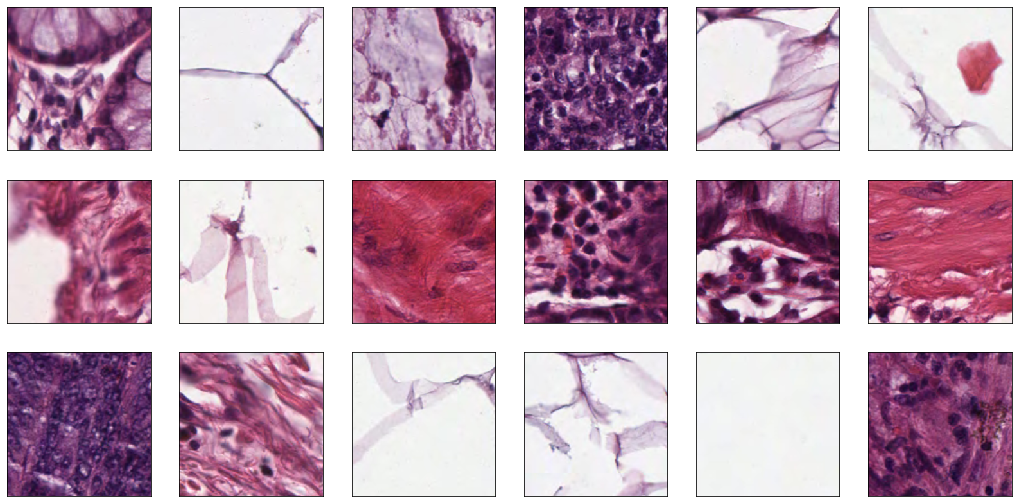

In [0]:
imgs = []
for X, y in train_iter:
    X = nd.swapaxes(X, 1, 3)
    imgs = X[0:18]
    break
    
    
show_images(imgs, 3, 6, titles=None, scale=3)